CODE BLOCK: 1

<!--
>**This is Bold**
>>*This is Italics*
>>>- Simple statement
>>> - `string`
>>>> - $ mathematical symbols $
>>>> 1. Number 1
>>>> 2. Number 2


&#x25BA;


*** -->

# Session 7 - Assignment
## Basic expectations
- \> = 99.4% accuracy
- < = 8000
- < = 15 epochs

## Step 5 - Image augmentation and adaptive LR scheduler

### Target:
- Look at images and use different image augmentations as per that to increase training complexity
  - Center Crop: 24 size crop to remove the outside 4 pixels to remove some edges
  - Image rotation: Checked and image rotation of +-20% seemed to be good
  - Random perspective change
  - Changes like brightness, contrast, saturation, hue, etc to have different types of images
- Use adaptive LR scheduler to help with adjusting learning rate with scaling factor of 0.2 (instead of 0.1 to learn a bit faster)
- Changed the batch size for training to 64 from 128 for it to backward propogate more times within same number of epochs
- Changed the model to have continuously increasing channels instead of increasing and decreasing

### Results:
- Epochs: 15
- Parameters: 7,528
- Training Batch size: 64
- Testing Batch size: 64
- Training
  - Loss=0.0440
  - Batch_id=938
  - Accuracy=98.63%
- Testing
  - Average loss: 0.0189
  - Accuracy: 9940/10000 (99.40%)
LR Rate: 0.002 

### Analysis:
- Kept the params same
- Accuracy has gone up and consistently matching our target
- Did not see any overfitting

### [1. Import appropriate modules required in this file](#section-1)
- import model: importing the code written in model.py that is kept in path of current working directory
- import utils: Similarly importing code in utils.py

In [1]:
# !pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

CODE BLOCK: 2

### [2. Check if GPU (CUDA) or CPU](#section-2)
- Cuda availablbility check to ensure using GPU if available for the network
- Taking the value into device variable if cuda (GPU) or only CPU

In [3]:
SEED = 1

use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if device=="cuda":
    torch.cuda.manual_seed(SEED)

CUDA Available? True


CODE BLOCK: 3

### [3. Data transforms for training and testing](#section-3)
- Transforms specific to the training and testing
- Training to include different transformations for the model to learn
- Testing not to have the same to ensure validation is on normal set

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([
      transforms.CenterCrop(size=(24,24)),
      transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
      transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
      transforms.RandomPerspective(distortion_scale=0.3, interpolation=3, fill=0),
      ], p=0.2
    ),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

### [4. Getting the MNIST train and test dataset from torchvision datasets library](#section-4)
- Already separated datasets for train and test
- train with *??* records and test with *10000* records
- Marking train as True of False decides the train vs test data sets
- The transforms are being loaded from utils file
- transforms being done on train but not on test

In [5]:
train = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

### [5. Data loader setup for Training and Testing](#section-5)
- Batch size definition - Keeping separate for Training and Testing
- Training lower for better training and Testing higher for faster validation
- Data loader definition

In [6]:
train_batch_size = 64
test_batch_size = 64

In [7]:
kwargs = {'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, **kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CODE BLOCK: 6

### [6. Data Visualization](#section-6)
- Visualization of data to understand the images and corresponding labels
- Also gives an understanding of the dataloader like Shuffle, etc.

torch.Size([64, 1, 28, 28])
torch.Size([64])


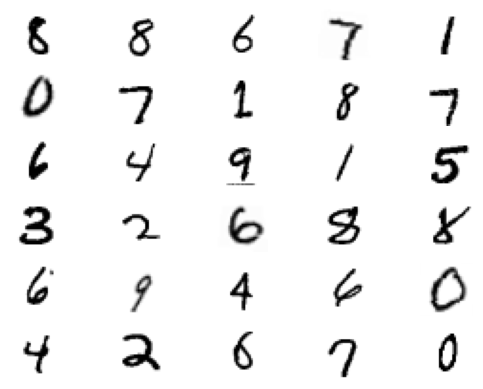

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(6, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

CODE BLOCK: 10

### [7. Model training](#section-7)
- Loading the model on the right device - CUDA or CPU
- Setting up the right parameters like epochs, optimizer and scheduler for the training
- Running the training and validating the output against Test dataset
- While doing that also storing the loss and accuracy results for each epoch for understanding

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [15]:
debug = True
dropout_value = 0.1
# Our base model
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        # Input Block
        self.convblock0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # TRANSITION BLOCK 1
        self.convblock_t_2 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 10

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3) # 7>> 9... nn.AdaptiveAvgPool((1, 1))
        ) # output_size = 1

    def forward(self, x):
        if (debug == True):
          print(f"Start: {x.shape}")

        x = self.convblock0(x)  # channel size 28 > 28  RF 1 > 3    J 1 > 1
        if (debug == True):
          print(f"Conv0: {x.shape}")

        x = self.convblock1(x)  # channel size 28 > 26  RF 3 > 5    J 1 > 1
        if (debug == True):
          print(f"Conv1: {x.shape}")
        x = self.pool1(x)         # channel size 26 > 13  RF 5 > 6    J 1 > 2
        if (debug == True):
          print(f"Pool1: {x.shape}")
        x = self.convblock2(x)  # channel size 13 > 11  RF 6 > 10    J 2 > 2
        if (debug == True):
          print(f"Conv2: {x.shape}")
        x = self.convblock3(x)  # channel size 11 > 9  RF 10 > 14    J 2 > 2
        if (debug == True):
          print(f"Conv3: {x.shape}")
        x = self.convblock4(x)  # channel size 9 > 7  RF 14 > 18    J 2 > 2
        if (debug == True):
          print(f"Conv4: {x.shape}")
        x = self.convblock5(x)  # channel size 7 > 5  RF 18 > 22    J 2 > 2
        if (debug == True):
          print(f"Conv5: {x.shape}")
        x = self.convblock6(x)  # channel size 5 > 3  RF 22 > 26    J 2 > 2
        if (debug == True):
          print(f"Conv6: {x.shape}")
        x = self.convblock_t_2(x)  # channel size 3 > 3  RF 26 > 26    J 2 > 2
        if (debug == True):
          print(f"Conv_t_2: {x.shape}")

        x = self.gap(x)
        if (debug == True):
          print(f"GAP: {x.shape}")

        x = x.view(-1, 10)        # 3 * 3 * 10
        if (debug == True):
          print(f"Flatten: {x.shape}")

        return F.log_softmax(x, dim=-1)

In [16]:
mymodel = Net3().to(device)

summary(mymodel, input_size=(1, 28, 28))

Start: torch.Size([2, 1, 28, 28])
Conv3_0_1: torch.Size([2, 8, 28, 28])
Conv3_1_1: torch.Size([2, 8, 26, 26])
Pool1: torch.Size([2, 8, 13, 13])
Conv3_1_2: torch.Size([2, 8, 11, 11])
Conv3_2_1: torch.Size([2, 8, 9, 9])
Conv3_2_2: torch.Size([2, 16, 7, 7])
Conv3_2_2: torch.Size([2, 16, 5, 5])
Conv3_2_2: torch.Size([2, 16, 3, 3])
Conv1_2_4: torch.Size([2, 10, 3, 3])
GAP: torch.Size([2, 10, 1, 1])
Flatten: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 26, 26]             576
       BatchNorm2d-6            [-1, 8, 26, 26]              16
              ReLU-7            [-1, 8, 26, 26]              

In [17]:
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc= 100*correct/processed
  print('\nProcessed: {}, Len TrainLoader: {}'.format(processed, len(train_loader)))
  # train_losses.append(train_loss/len(train_loader))
  train_loss = train_loss/len(train_loader)
  print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
      train_loss, correct, len(train_loader.dataset),
      100. * correct / len(train_loader.dataset)))

  return train_acc, train_loss

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc = (100. * correct / len(test_loader.dataset))
    # test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_acc, test_loss

In [18]:
debug = False
optimizer = optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.2, threshold_mode='rel', verbose=True)
criterion = F.nll_loss
num_epochs = 15

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = train(mymodel, device, train_loader, optimizer, criterion)
  test_acc, test_loss = test(mymodel, device, test_loader, criterion)
  scheduler.step(test_loss)
  print("LR Rate:", optimizer.param_groups[0]['lr'], "\n")
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  test_accs.append(test_acc)
  test_losses.append(test_loss)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=0.1485 Batch_id=937 Accuracy=88.49: 100%|██████████| 938/938 [00:29<00:00, 31.53it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.4083, Accuracy: 53096/60000 (88.49%)


Test set: Average loss: 0.0551, Accuracy: 9830/10000 (98.30%)
LR Rate: 0.01 

Epoch 2


Train: Loss=0.0297 Batch_id=937 Accuracy=96.89: 100%|██████████| 938/938 [00:30<00:00, 30.77it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.1038, Accuracy: 58132/60000 (96.89%)


Test set: Average loss: 0.0420, Accuracy: 9871/10000 (98.71%)
LR Rate: 0.01 

Epoch 3


Train: Loss=0.0323 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [00:30<00:00, 30.84it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0812, Accuracy: 58538/60000 (97.56%)


Test set: Average loss: 0.0313, Accuracy: 9893/10000 (98.93%)
LR Rate: 0.01 

Epoch 4


Train: Loss=0.0525 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:32<00:00, 29.27it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0774, Accuracy: 58607/60000 (97.68%)


Test set: Average loss: 0.0284, Accuracy: 9908/10000 (99.08%)
LR Rate: 0.01 

Epoch 5


Train: Loss=0.0015 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0678, Accuracy: 58730/60000 (97.88%)


Test set: Average loss: 0.0292, Accuracy: 9905/10000 (99.05%)
LR Rate: 0.01 

Epoch 6


Train: Loss=0.0830 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:32<00:00, 29.28it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0668, Accuracy: 58722/60000 (97.87%)


Test set: Average loss: 0.0266, Accuracy: 9919/10000 (99.19%)
LR Rate: 0.01 

Epoch 7


Train: Loss=0.0654 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:32<00:00, 29.14it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0638, Accuracy: 58802/60000 (98.00%)


Test set: Average loss: 0.0260, Accuracy: 9914/10000 (99.14%)
LR Rate: 0.01 

Epoch 8


Train: Loss=0.0205 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:30<00:00, 30.47it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0611, Accuracy: 58885/60000 (98.14%)


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)
LR Rate: 0.01 

Epoch 9


Train: Loss=0.0346 Batch_id=937 Accuracy=98.23: 100%|██████████| 938/938 [00:31<00:00, 29.75it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0589, Accuracy: 58936/60000 (98.23%)


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)
LR Rate: 0.01 

Epoch 10


Train: Loss=0.0126 Batch_id=937 Accuracy=98.24: 100%|██████████| 938/938 [00:30<00:00, 30.68it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0572, Accuracy: 58943/60000 (98.24%)


Test set: Average loss: 0.0251, Accuracy: 9926/10000 (99.26%)
LR Rate: 0.01 

Epoch 11


Train: Loss=0.0114 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:30<00:00, 30.56it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0551, Accuracy: 58978/60000 (98.30%)


Test set: Average loss: 0.0230, Accuracy: 9918/10000 (99.18%)
LR Rate: 0.002 

Epoch 12


Train: Loss=0.0371 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:31<00:00, 29.43it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0458, Accuracy: 59152/60000 (98.59%)


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)
LR Rate: 0.002 

Epoch 13


Train: Loss=0.2140 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:30<00:00, 30.44it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0446, Accuracy: 59164/60000 (98.61%)


Test set: Average loss: 0.0189, Accuracy: 9933/10000 (99.33%)
LR Rate: 0.002 

Epoch 14


Train: Loss=0.0028 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:32<00:00, 29.17it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0436, Accuracy: 59167/60000 (98.61%)


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)
LR Rate: 0.002 

Epoch 15


Train: Loss=0.0166 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:30<00:00, 30.28it/s]


Processed: 60000, Len TrainLoader: 938
Train set: Average loss: 0.0440, Accuracy: 59178/60000 (98.63%)


Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)
LR Rate: 0.002 



CODE BLOCK: 11

### [8. Model Accuracy and Loss plots visualization](#section-8)
- Part of utils
- Drawing plots of Training and Testing accuracy and loss
- This gives us an understanding of how the accuracy and losses improved over epochs
- Also helps to understand where we should have stopped the training for optimum results

In [19]:
# utils.drawLossAccuracyPlots(train_losses, train_accs, test_losses, test_accs)

Text(0.5, 1.0, 'Test Accuracy')

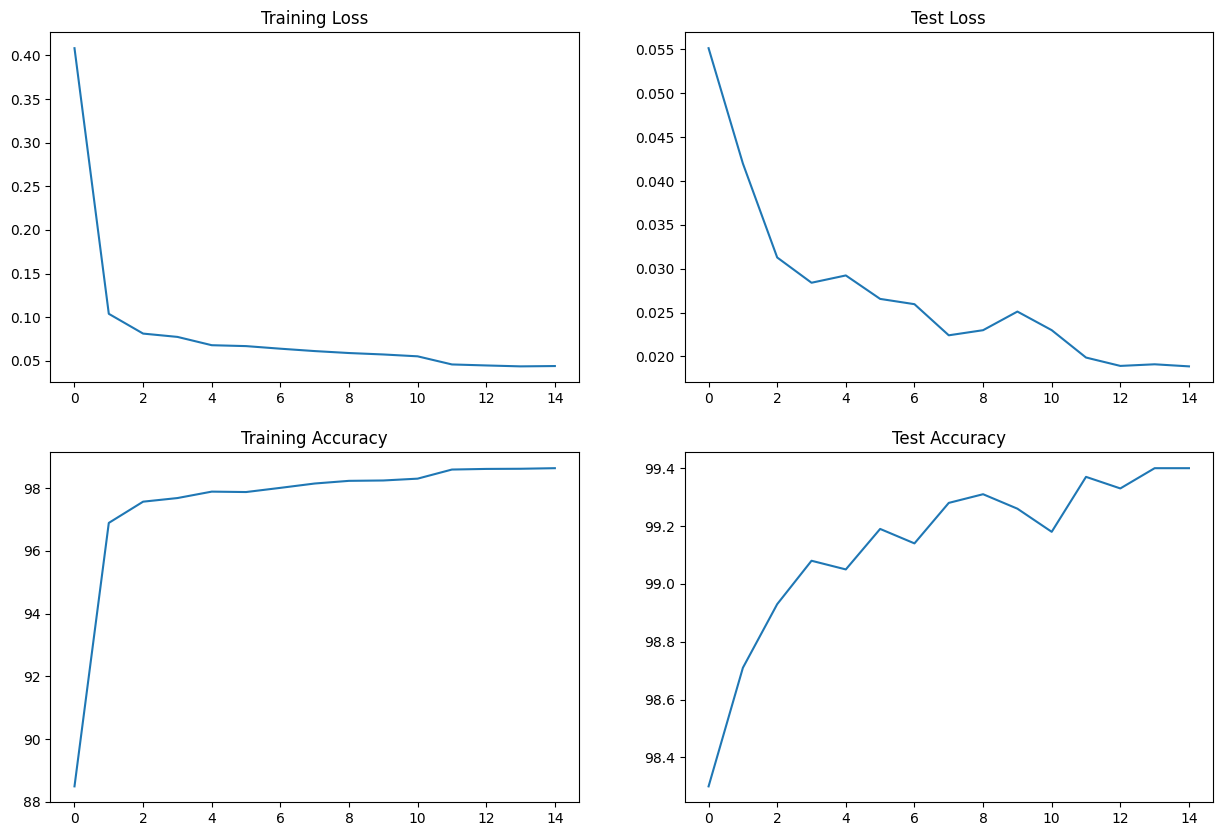

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")